# 猫狗比赛

In [1]:
%pwd

u'/home/ubuntu/nbs'

In [50]:
import os, sys
DATA_HOME_DIR = '/home/ubuntu/nbs/competition/redux'
LESSON_HOME_DIR = '/home/ubuntu/nbs/competition/redux'

In [3]:
sys.path.insert(0, '/home/ubuntu/nbs/')
print(sys.path)

['/home/ubuntu/nbs/', '', '/home/ubuntu/anaconda2/lib/python27.zip', '/home/ubuntu/anaconda2/lib/python2.7', '/home/ubuntu/anaconda2/lib/python2.7/plat-linux2', '/home/ubuntu/anaconda2/lib/python2.7/lib-tk', '/home/ubuntu/anaconda2/lib/python2.7/lib-old', '/home/ubuntu/anaconda2/lib/python2.7/lib-dynload', '/home/ubuntu/anaconda2/lib/python2.7/site-packages', '/home/ubuntu/anaconda2/lib/python2.7/site-packages/Sphinx-1.4.6-py2.7.egg', '/home/ubuntu/anaconda2/lib/python2.7/site-packages/setuptools-27.2.0-py2.7.egg', '/home/ubuntu/anaconda2/lib/python2.7/site-packages/IPython/extensions', '/home/ubuntu/.ipython']


In [4]:

#import modules
from utils import *
from vgg16 import Vgg16

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [5]:
%matplotlib inline

In [8]:
%cd $DATA_HOME_DIR
%mkdir valid
%mkdir results
%mkdir -p sample/train
%mkdir -p sample/test
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p test/unknown

/home/ubuntu/nbs/competition/redux
mkdir: cannot create directory ‘valid’: File exists
mkdir: cannot create directory ‘results’: File exists


In [6]:
%mkdir -p sample/test/unknown

In [14]:
%cd $DATA_HOME_DIR/train

/home/ubuntu/nbs/competition/redux/train


In [9]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(2000): os.rename(shuf[i], DATA_HOME_DIR+'/valid/' + shuf[i])

IndexError: index 0 is out of bounds for axis 0 with size 0

In [13]:
from shutil import copyfile

In [27]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(100): copyfile(shuf[i], DATA_HOME_DIR+'/sample/train/' + shuf[i])

In [29]:
%cd $DATA_HOME_DIR/valid

/home/ubuntu/nbs/competition/redux/valid


In [30]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(50): copyfile(shuf[i], DATA_HOME_DIR+'/sample/valid/' + shuf[i])

In [19]:
%cd $DATA_HOME_DIR/test/unknown
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(64): copyfile(shuf[i], DATA_HOME_DIR+'/sample/test/unknown/' + shuf[i])

/home/ubuntu/nbs/competition/redux/test/unknown


In [ ]:
#Divide cat/dog images into separate directories

%cd $DATA_HOME_DIR/sample/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/sample/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

In [ ]:
# Create single 'unknown' class for test set
%cd $DATA_HOME_DIR/test
%mv *.jpg unknown/

In [20]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR + '/sample/'
test_path = DATA_HOME_DIR + '/test/' #We use all the test data
results_path=DATA_HOME_DIR + '/results/'
train_path=path + '/train/'
valid_path=path + '/valid/'

/home/ubuntu/nbs/competition/redux


In [21]:
#import Vgg16 helper class
vgg = Vgg16()

In [22]:
#Set constants. You can experiment with no_of_epochs to improve the model
batch_size=64
no_of_epochs=1

In [23]:
#Finetune the model
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)
vgg.finetune(batches)

#Not sure if we set this for all fits
vgg.model.optimizer.lr = 0.01

Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [24]:
#Notice we are passing in the validation dataset to the fit() method
#For each epoch we test our model against the validation set
latest_weights_filename = None
for epoch in range(no_of_epochs):
    print "Running epoch: %d" % epoch
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(results_path+latest_weights_filename)
print "Completed %s fit operations" % no_of_epochs

Running epoch: 0
Epoch 1/1
200/200 [==============================] - 9s - loss: 1.3577 - acc: 0.7550 - val_loss: 0.2797 - val_acc: 0.9800
Completed 1 fit operations


In [25]:
batches, preds = vgg.test(test_path, batch_size = batch_size*2)

Found 12500 images belonging to 1 classes.


In [26]:
#For every image, vgg.test() generates two probabilities 
#based on how we've ordered the cats/dogs directories.
#It looks like column one is cats and column two is dogs
print preds[:5]

filenames = batches.filenames
print filenames[:5]

[[  1.0000e+00   1.4152e-25]
 [  9.9999e-01   1.2004e-05]
 [  1.0000e+00   1.1994e-18]
 [  1.0000e+00   1.5627e-29]
 [  1.7220e-13   1.0000e+00]]
['unknown/9292.jpg', 'unknown/12026.jpg', 'unknown/9688.jpg', 'unknown/4392.jpg', 'unknown/779.jpg']


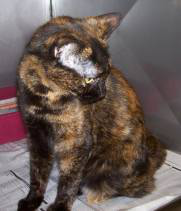

In [27]:

#You can verify the column ordering by viewing some images
from PIL import Image
Image.open(test_path + filenames[2])

In [28]:
#Save our test results arrays so we can use them again later
save_array(results_path + 'test_preds.dat', preds)
save_array(results_path + 'filenames.dat', filenames)

In [29]:
vgg.model.load_weights(results_path+latest_weights_filename)

In [30]:
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)

Found 50 images belonging to 2 classes.


In [31]:
filenames = val_batches.filenames
expected_labels = val_batches.classes #0 or 1

#Round our predictions to 0/1 to generate labels
our_predictions = probs[:,0]
our_labels = np.round(1-our_predictions)

In [32]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

Found 49 correct labels


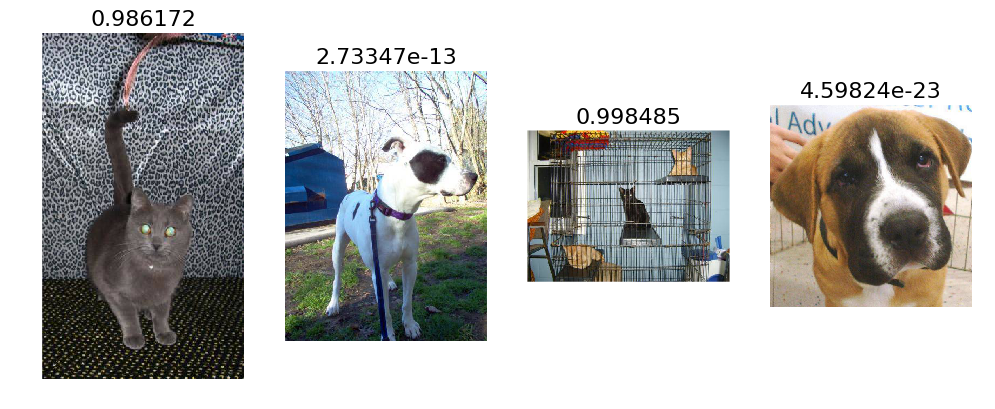

In [33]:
#1. A few correct labels at random
correct = np.where(our_labels==expected_labels)[0]
print "Found %d correct labels" % len(correct)
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 1 incorrect labels


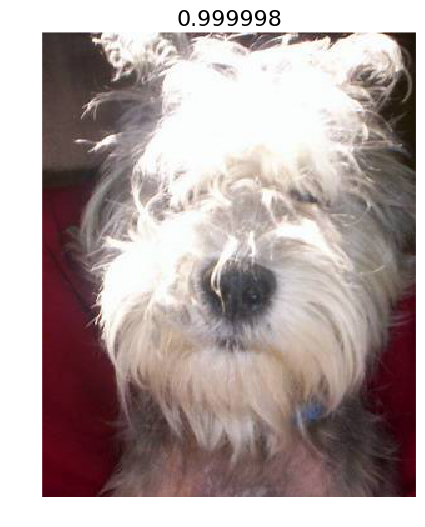

In [34]:
#2. A few incorrect labels at random
incorrect = np.where(our_labels!=expected_labels)[0]
print "Found %d incorrect labels" % len(incorrect)
idx = permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 30 confident correct cats labels


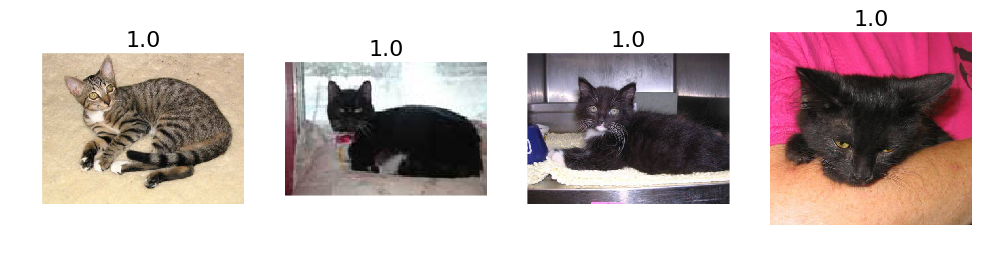

In [35]:
#3a. The images we most confident were cats, and are actually cats
correct_cats = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print "Found %d confident correct cats labels" % len(correct_cats)
most_correct_cats = np.argsort(our_predictions[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

Found 19 confident correct dogs labels


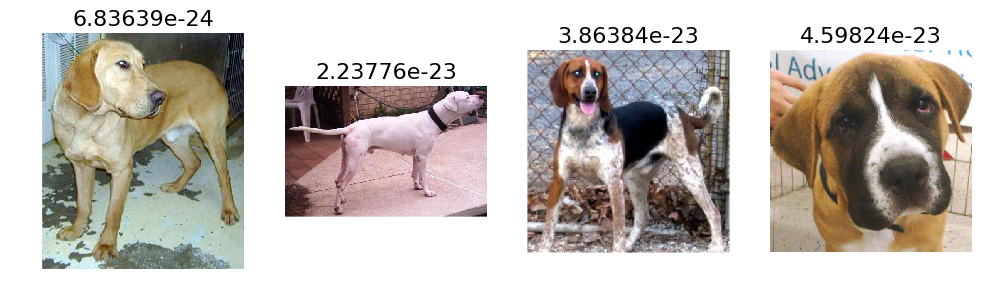

In [36]:
#3b. The images we most confident were dogs, and are actually dogs
correct_dogs = np.where((our_labels==1) & (our_labels==expected_labels))[0]
print "Found %d confident correct dogs labels" % len(correct_dogs)
most_correct_dogs = np.argsort(our_predictions[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], our_predictions[correct_dogs][most_correct_dogs])

Found 1 incorrect cats


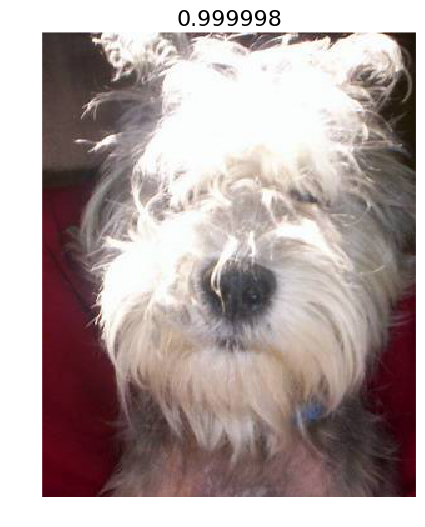

In [37]:
#4a. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print "Found %d incorrect cats" % len(incorrect_cats)
if len(incorrect_cats):
    most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
    plots_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats])

In [38]:
#4b. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print "Found %d incorrect dogs" % len(incorrect_dogs)
if len(incorrect_dogs):
    most_incorrect_dogs = np.argsort(our_predictions[incorrect_dogs])[:n_view]
    plots_idx(incorrect_dogs[most_incorrect_dogs], our_predictions[incorrect_dogs][most_incorrect_dogs])

Found 0 incorrect dogs


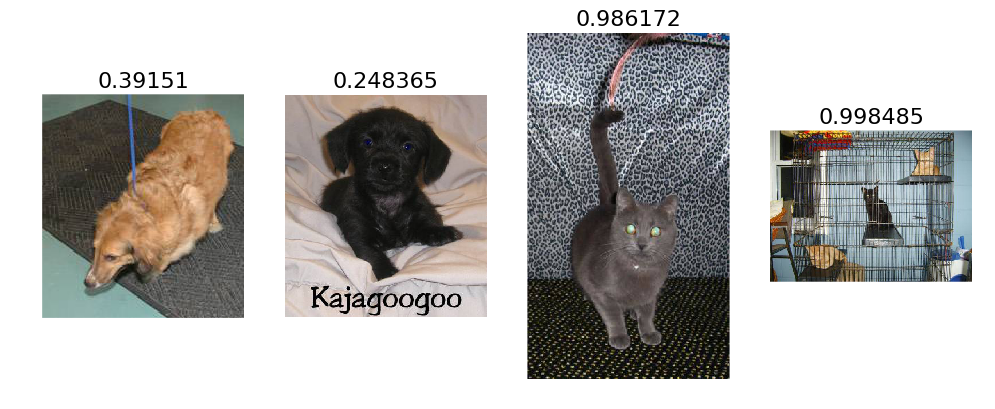

In [39]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])

In [40]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

[[30  0]
 [ 1 19]]


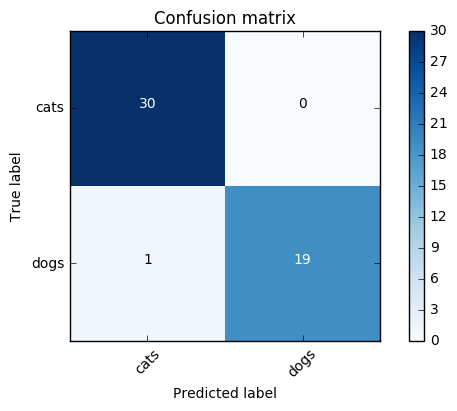

In [41]:
plot_confusion_matrix(cm, val_batches.class_indices)

In [42]:
#Load our test predictions from file
preds = load_array(results_path + 'test_preds.dat')
filenames = load_array(results_path + 'filenames.dat')

In [43]:
#Grab the dog prediction column
isdog = preds[:,1]
print "Raw Predictions: " + str(isdog[:5])
print "Mid Predictions: " + str(isdog[(isdog < .6) & (isdog > .4)])
print "Edge Predictions: " + str(isdog[(isdog == 1) | (isdog == 0)])

Raw Predictions: [  1.4152e-25   1.2004e-05   1.1994e-18   1.5627e-29   1.0000e+00]
Mid Predictions: [ 0.4875  0.4768  0.4946  0.5057  0.5284  0.5568  0.5404  0.5456  0.4874  0.5086  0.5644  0.5098
  0.447   0.5671  0.5478  0.5082  0.4033  0.5769  0.4986  0.4665  0.4733  0.5938  0.5805  0.4778
  0.4892  0.4666  0.5114  0.5632  0.447   0.4924  0.4181  0.424   0.5814  0.4012  0.5583  0.5794
  0.5194  0.4838  0.4163  0.5461  0.5911  0.5946  0.4896  0.4439  0.4456  0.497   0.5503  0.5684
  0.4318  0.5594  0.4961  0.5621  0.4278  0.5879  0.5039  0.504   0.5256  0.5319]
Edge Predictions: [ 1.  1.  1. ...,  1.  1.  1.]


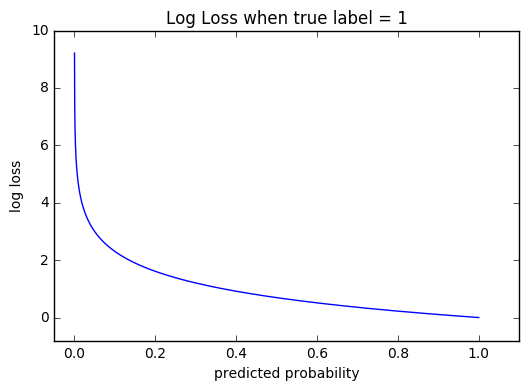

In [44]:
#Visualize Log Loss when True value = 1
#y-axis is log loss, x-axis is probabilty that label = 1
#As you can see Log Loss increases rapidly as we approach 0
#But increases slowly as our predicted probability gets closer to 1
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss

x = [i*.0001 for i in range(1,10000)]
y = [log_loss([1],[[i*.0001,1-(i*.0001)]],eps=1e-15) for i in range(1,10000,1)]

plt.plot(x, y)
plt.axis([-.05, 1.1, -.8, 10])
plt.title("Log Loss when true label = 1")
plt.xlabel("predicted probability")
plt.ylabel("log loss")

plt.show()

In [45]:
#So to play it safe, we use a sneaky trick to round down our edge predictions
#Swap all ones with .95 and all zeros with .05
isdog = isdog.clip(min=0.05, max=0.95)

In [46]:
#Extract imageIds from the filenames in our test/unknown directory 
filenames = batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

In [47]:
subm = np.stack([ids,isdog], axis=1)
subm[:5]

array([[  9.2920e+03,   5.0000e-02],
       [  1.2026e+04,   5.0000e-02],
       [  9.6880e+03,   5.0000e-02],
       [  4.3920e+03,   5.0000e-02],
       [  7.7900e+02,   9.5000e-01]])

In [53]:
%cd $DATA_HOME_DIR
submission_file_name = 'submission1.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

/home/ubuntu/nbs/competition/redux


In [55]:
from IPython.display import FileLink
%cd $LESSON_HOME_DIR
FileLink(submission_file_name)

/home/ubuntu/nbs/competition/redux


/home/ubuntu/nbs/competition/redux/submission1.csv